In [ ]:
!unzip toxic.zip

Archive:  toxic.zip
  inflating: labeled.csv             


In [ ]:
!pip install fasttext
!pip install pymorphy2
!pip install simpletransformers

In [ ]:
import pandas as pd
import fasttext
import fasttext.util
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download("punkt")
import matplotlib.pyplot as plt
import seaborn as sns
from pymorphy2 import MorphAnalyzer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from scipy.sparse import hstack, vstack
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import re
import numpy as np
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
fasttext.util.download_model('ru', if_exists='ignore')  
ft = fasttext.load_model('cc.ru.300.bin')

#Одни данные

In [ ]:
df = pd.read_csv("labeled.csv")
df

FileNotFoundError: ignored

In [ ]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+\n"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    tags = doc
    tokens = []
    tags = re.sub(patterns, ' ', tags)
    for token in tags.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]             
            tokens.append(token)
    if len(tokens) > 2:        
        return " ".join(tokens)
    return None

def vectorize(doc):
  vector = ft.get_sentence_vector(doc)
  return vector
  
df['comment'] = df['comment'].apply(lemmatize)
df.dropna(inplace=True)
df['comment'] = df['comment'].apply(vectorize)
y = df['toxic']
x = df['comment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [ ]:
df['toxic'].value_counts()

0.0    9488
1.0    4741
Name: toxic, dtype: int64

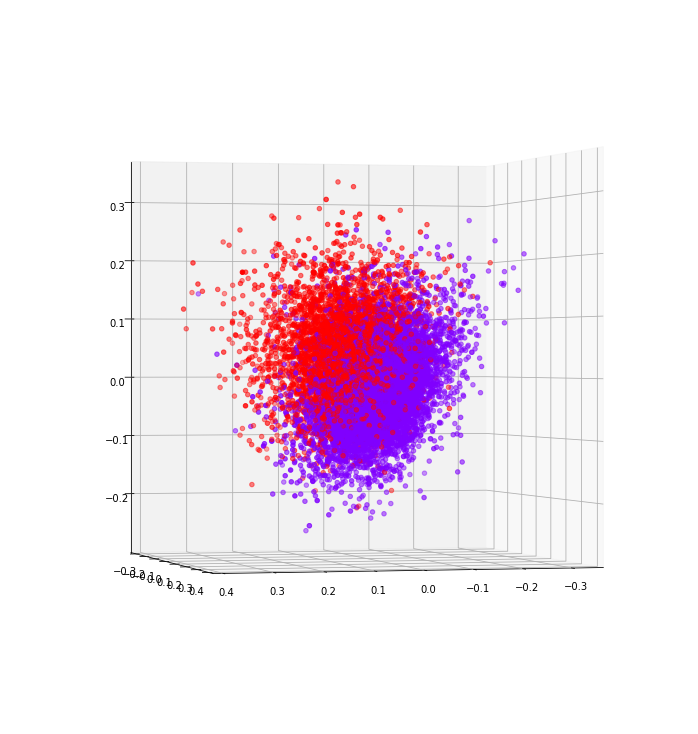

In [ ]:
pca = PCA(3)
x_st = pca.fit_transform(df['comment'].values.tolist())
y_st = df['toxic']
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=0, azim=75)
ax.scatter(x_st[:, 0],x_st[:, 1],x_st[:, 2], c=y_st, cmap='rainbow')

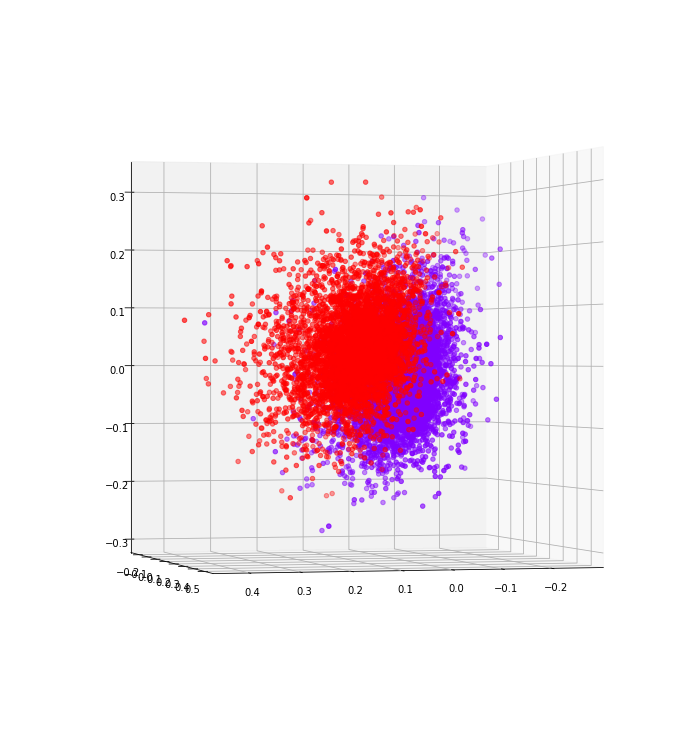

In [ ]:
pca = PCA(3)
x_st = pca.fit_transform(x)
y_st = df['toxic']
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=0, azim=75)
ax.scatter(x_st[:, 0],x_st[:, 1],x_st[:, 2], c=y, cmap='rainbow')

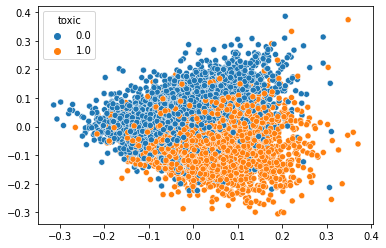

In [ ]:
pca_2 = PCA(2)
x_st2 = pca_2.fit_transform(df['comment'].values.tolist())
sns.scatterplot(x=x_st2[:, 0], y=x_st2[:, 1], hue=y_st)

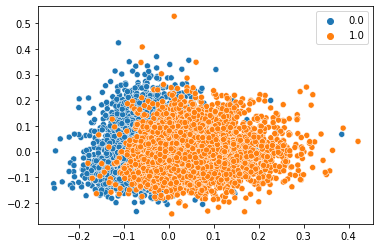

In [ ]:
pca_2 = PCA(2)
x_st2 = pca_2.fit_transform(x)
sns.scatterplot(x=x_st2[:, 0], y=x_st2[:, 1], hue=y)

In [ ]:
x = df['comment']
y = df['toxic']
x.shape, y.shape

smote = SMOTE(random_state=42, sampling_strategy=0.7)
r_und = RandomUnderSampler(random_state=42, sampling_strategy=0.6)

x, y = r_und.fit_resample(x.values.tolist(), y)
x, y = smote.fit_resample(x, y)

count_t = 0
count_f = 0
for i in range(len(y)):
  if y[i] == 1:
    count_t += 1
  else:
    count_f += 1
count_t, count_f

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Без SMOTE и RandomUnderSampling
svm = SVC(random_state=42, C=1, kernel='rbf', probability=True)
svm.fit(x_train.values.tolist(), y_train)
preds = svm.predict(x_test.values.tolist())
print("Accuracy: ", accuracy_score(y_test, preds))
print("F1-Score: ", f1_score(y_test, preds))
print("ROC-AUC score: ", roc_auc_score(y_test, preds))

Accuracy:  0.9013820566877488
F1-Score:  0.8504440497335701
ROC-AUC score:  0.882960820051131


In [ ]:
#С SMOTE и RandomUnderSampling
svm = SVC(random_state=42, C=1, kernel='rbf', probability=True)
svm.fit(x_train, y_train)
preds = svm.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, preds))
print("F1-Score: ", f1_score(y_test, preds))
print("ROC-AUC score: ", roc_auc_score(y_test, preds))

Accuracy:  0.9049627791563275
F1-Score:  0.881753627662859
ROC-AUC score:  0.8992417146170658


In [ ]:
svm = RandomForestClassifier(random_state=42)
svm.fit(x_train.values.tolist(), y_train)
preds = svm.predict(x_test.values.tolist())
print("Accuracy: ", accuracy_score(y_test, preds))
print("F1-Score: ", f1_score(y_test, preds))
print("ROC-AUC score: ", roc_auc_score(y_test, preds))

Accuracy:  0.8664792691496838
F1-Score:  0.783763277693475
ROC-AUC score:  0.8290696138273539


In [ ]:
svm = RidgeClassifier(random_state=42)
svm.fit(x_train.values.tolist(), y_train)
preds = svm.predict(x_test.values.tolist())
print("Accuracy: ", accuracy_score(y_test, preds))
print("F1-Score: ", f1_score(y_test, preds))
print("ROC-AUC score: ", roc_auc_score(y_test, preds))

Accuracy:  0.8849847739517451
F1-Score:  0.814366729678639
ROC-AUC score:  0.8504499027534831


In [ ]:
test_text = "ёдрен батон"
test_w = ft.get_sentence_vector(test_text)
svm.predict(test_w.reshape(1, -1))

array([1.])

#Другие данные

In [ ]:
!unzip chat.zip

Archive:  chat.zip
  inflating: messages.csv            


In [ ]:
df_chat = pd.read_csv("messages.csv")
df_chat

,date,msg
0,2012-01-02 00:21:00,нужен парень 0965188229
1,2012-01-02 00:24:00,Всем привет! Как настроение?
2,2012-01-02 00:27:00,ИЩЮ ВТОРУЮ ПОЛОВИНКУ МНЕ 23 ЗОВУТ ВАНЯ ПИШИТЕ ...
3,2012-01-02 00:27:00,Эля встречала в шумной компании! Все отлично!
4,2012-01-02 00:27:00,Парень катается по городу. Нужна девушка. 0992...
...,...,...
1147095,2017-02-01 00:22:00,парень 34 ищет женщину до 38 для жизни. Энерго...
1147096,2017-02-01 00:22:00,Парень ищет девушку для С.О.С.С.0990157324)(09...
1147097,2017-02-01 00:22:00,познакомлюсь с д/ж для и/о сейчас жду.099934
1147098,2017-02-01 00:24:00,мущина познакомится с женщиной с огромной г***...


In [ ]:
df_chat.isna().sum()

date    0
msg     0
dtype: int64

In [ ]:
len(df_chat)

1147100

In [ ]:
patterns = r"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [morph.normal_forms(word)[0] for word in words]
    words = [word for word in words if not word in stopwords_ru]
    if len(words) > 2:        
        return " ".join(words)
    return None

data = df_chat['msg'].apply(lemmatize)

In [ ]:
data.dropna(inplace=True)

In [ ]:
def vectorize(doc):
  words = ft.get_sentence_vector(doc)
  return words

data = data.apply(vectorize)

In [ ]:
x = np.array(data.values.tolist())
x.shape

(1067277, 300)

In [ ]:
lda_topics = ["x1", "x2", 'x3', 'x4', 'x5']

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tf_data = tfidf.fit_transform(data)

In [ ]:
lda = LatentDirichletAllocation(n_components=5)
lda.fit(tf_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
def get_model_topics(model, vectorizer, topics, n_top_words=20):
    word_dict = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features

    return pd.DataFrame(word_dict)

In [ ]:
results_df = get_model_topics(lda, tfidf, lda_topics)

In [ ]:
results_df

,x1,x2,x3,x4,x5
0,искать,любить,скучать,познакомиться,дева
1,парень,хороший,парень,девушка,позна
2,девушка,хотеть,девушка,парень,смс
3,далее,всё,привет,год,пара
4,днепр,искать,пригласить,женщина,искать
5,смс,который,гость,общение,днепр
6,год,твой,звонить,смс,далее
7,задержать,код,приехать,искать,встреча
8,отношение,любимый,ребёнок,далее,ммс
9,запорожье,кліп,хотеть,днепр,познак


#Тест

In [1]:
!unzip nlp.zip

Archive:  nlp.zip
  inflating: news.csv                


In [2]:
!pip install sentence_transformers 

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 1.9MB 15.5MB/s 
     |████████████████████████████████| 1.2MB 38.7MB/s 
     |████████████████████████████████| 3.2MB 39.2MB/s 
     |████████████████████████████████| 890kB 35.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp37-none-any.whl size=103068 sha256=77ad7d393c504cc6db35a9e1ff75b110d605b11dcec8f7ae7237ccbc3569c128
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=10acbd84f98f62e3469bd8c271b567a8e73a824ed22078005ced52fead815c0c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [3]:
!pip install hdbscan

     |████████████████████████████████| 6.4MB 11.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311676 sha256=8ea9ce1c5f66f24f4aad9401bb2a91ccee8b0017c9a53740ac171474fe1509b8
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


In [57]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
import umap
import matplotlib.pyplot as plt
import hdbscan
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download("punkt")
import re

df = pd.read_csv("news.csv")
df = df.replace('\n','', regex=True)
patterns = r"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [word for word in words if not word in stopwords_ru]
    if len(words) > 2:        
        return " ".join(words)
    return None
  
data = df['text'].apply(lemmatize)

model = SentenceTransformer('stsb-distilbert-base')
embeddings = model.encode(data, show_progress_bar=True)

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


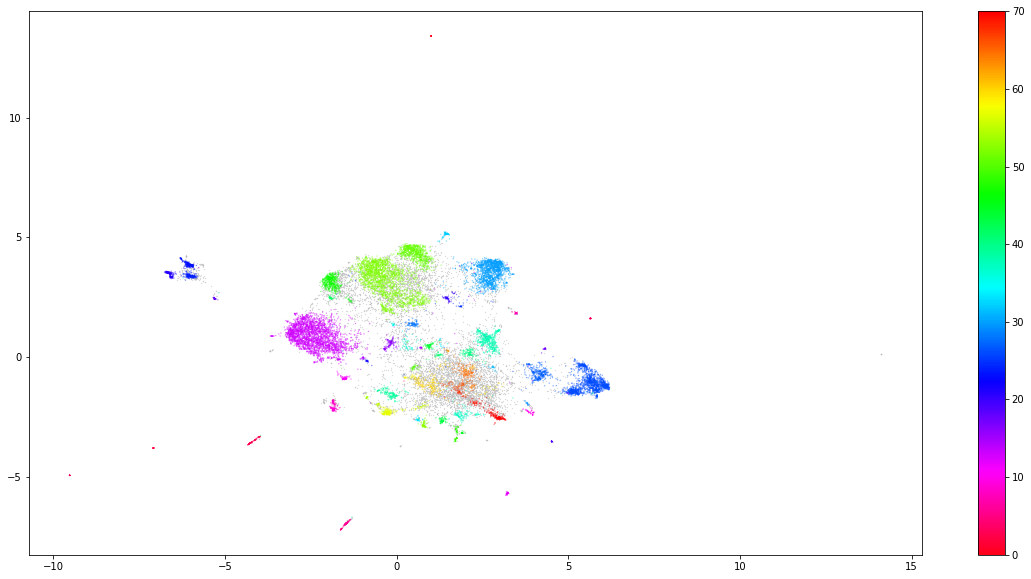

In [39]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [44]:
docs_df = pd.DataFrame(data)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'text': ' '.join})

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(data))

In [45]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,7715
14,13,2792
53,52,2069
27,26,1494
31,30,1479
52,51,763
39,38,496
48,47,467
28,27,327
24,23,205


In [53]:
top_n_words[26][:30]

[('вашингтон', 0.017391975398285523),
 ('трамп', 0.01332847045615633),
 ('сша', 0.01094191019080876),
 ('дональд', 0.007631755870942402),
 ('трампа', 0.0074857031105135426),
 ('президент', 0.006403843642859756),
 ('помпео', 0.0048584166939430904),
 ('сказал', 0.00469354766891895),
 ('президента', 0.004672237153838189),
 ('заявил', 0.004558584363748296),
 ('долларов', 0.004181370123802735),
 ('американских', 0.003995343156818558),
 ('говорится', 0.003703930060292423),
 ('ранее', 0.003691910251636854),
 ('госсекретарь', 0.0035557545071858766),
 ('мы', 0.0034796824651111944),
 ('против', 0.003469064359632046),
 ('белого', 0.0033909006958836984),
 ('дональда', 0.003351739016256804),
 ('данные', 0.003348846072464826)]

In [60]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("text", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'text': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.text.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,7903
11,10,2792
38,37,2141
19,18,1494
22,21,1479
37,36,763
27,26,496
34,33,484
20,19,347
42,41,211
